In [98]:
import os
import sys
import numpy as np
import sklearn as skl
import time
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

sys.path.append("../../../")
import CalibratedTimeseriesModels

from CalibratedTimeseriesModels.utils import *
from CalibratedTimeseriesModels.models.gnn import *
from CalibratedTimeseriesModels.models.gmnn import *
from CalibratedTimeseriesModels.models.blr import *
from CalibratedTimeseriesModels.evaluators import ExplicitEvaluator

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
# load data
X_orig = torch.load("../../../datasets/processed/openEI/X_openei_011_subset_multitask.pt")
Y_orig = torch.load("../../../datasets/processed/openEI/Y_openei_011_subset_multitask.pt")

past_dims = 24
fut_dims = 12

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = electric_train_test_split(X_orig, Y_orig, 
                                                                                 disp_idx=past_dims+fut_dims)

In [100]:
X_train = X_train_orig[1,:,:past_dims].reshape((-1,past_dims)).unsqueeze(-1).float()
Y_train_full = Y_train_orig[1,:,:fut_dims].reshape((-1,fut_dims)).unsqueeze(-1).float()
X_test = X_test_orig[1,:,:past_dims].reshape((-1,past_dims)).unsqueeze(-1).float()
Y_test_full = Y_test_orig[1,:,:fut_dims].reshape((-1,fut_dims)).unsqueeze(-1).float()

Y_train = Y_train_full[:,[0],:]
Y_test = Y_test_full[:,[0],:]

X_batches, Y_batches = batch(X_train, Y_train, batch_size = 128)

### Single Step LR

In [101]:
lin_reg = BayesianLinearRegression(1, past_dims, 1, 1)
lin_reg.fit(X_train, Y_train)
dtest0 = lin_reg(X_test)
for f in [mape, wape, rmse, rwse, nll]:
    print(f(dtest0,Y_test))

(tensor(0.0498), tensor([0.0498]), tensor([0.0485]))
(tensor(0.0755), tensor([0.0755]), tensor([0.0437]))
(tensor(0.0740), tensor([0.0055]), tensor([0.0109]))
(tensor(0.0968), tensor([0.0094]), tensor([0.0108]))
(tensor(-1.1517), tensor([-1.8114, -1.8524, -1.6308,  ..., -1.3601, -0.6647, -1.0643]))


### Single Step GNN

In [41]:
hidden_layers = [40, 40, 40]
ss_gnn = GaussianNeuralNet(1, past_dims, hidden_layers, 1, 1)
train(ss_gnn, X_batches, Y_batches, num_epochs=150, learning_rate=.005)
dtest_gnn = ss_gnn(X_test)
for f in [mape, wape, rmse, rwse, nll]:
    print(f(dtest_gnn,Y_test))

epoch : 1, loss: 0.4372
epoch : 11, loss: -1.3281
epoch : 21, loss: -1.3911
epoch : 31, loss: -1.4123
epoch : 41, loss: -1.5076
epoch : 51, loss: -1.4680
epoch : 61, loss: -1.7906
epoch : 71, loss: -1.6621
epoch : 81, loss: -1.7677
epoch : 91, loss: -1.9560
epoch : 101, loss: -1.8870
epoch : 111, loss: -1.7548
epoch : 121, loss: -2.0011
epoch : 131, loss: -1.9669
epoch : 141, loss: -1.8842
Learning finished!
(tensor(0.0338, grad_fn=<MeanBackward0>), tensor([0.0338], grad_fn=<MeanBackward1>), tensor([0.0385], grad_fn=<StdBackward1>))
(tensor(0.0452), tensor([0.0452]), tensor([0.0348]))
(tensor(0.0573, grad_fn=<PowBackward0>), tensor([0.0033], grad_fn=<MeanBackward1>), tensor([0.0082], grad_fn=<StdBackward1>))
(tensor(0.0754), tensor([0.0057]), tensor([0.0096]))
(tensor(-1.6022, grad_fn=<MeanBackward0>), tensor([-3.1669, -3.1733, -2.9779,  ..., -0.1438, -0.7907, -1.7754],
       grad_fn=<SumBackward1>))


### Single Step GMNN

In [42]:
hidden_layers = [40, 40, 40]
ss_gmnn = GaussianMixtureNeuralNet(1, past_dims, hidden_layers, 1, 1, n_components=3)
train(ss_gmnn, X_batches, Y_batches, num_epochs=150, learning_rate=.005)
dtest_gmnn = ss_gmnn(X_test)
for f in [mape, wape, rmse, rwse, nll]:
    print(f(dtest_gmnn,Y_test))

epoch : 1, loss: 0.7016
epoch : 11, loss: -1.2484
epoch : 21, loss: -1.4711
epoch : 31, loss: -1.6136
epoch : 41, loss: -1.6917
epoch : 51, loss: -1.6859
epoch : 61, loss: -1.7611
epoch : 71, loss: -1.9041
epoch : 81, loss: -1.8746
epoch : 91, loss: -1.9587
epoch : 101, loss: -1.8054
epoch : 111, loss: -1.9890
epoch : 121, loss: -1.8087
epoch : 131, loss: -1.6759
epoch : 141, loss: -2.0839
Learning finished!
(tensor(0.0343, grad_fn=<MeanBackward0>), tensor([0.0343], grad_fn=<MeanBackward1>), tensor([0.0377], grad_fn=<StdBackward1>))
(tensor(0.0547), tensor([0.0547]), tensor([0.0334]))
(tensor(0.0575, grad_fn=<PowBackward0>), tensor([0.0033], grad_fn=<MeanBackward1>), tensor([0.0068], grad_fn=<StdBackward1>))
(tensor(0.0877), tensor([0.0077]), tensor([0.0088]))
(tensor(-1.6733, grad_fn=<MeanBackward0>), tensor([-2.7498, -2.8066, -2.7430,  ..., -1.3938, -2.2997, -2.0622],
       grad_fn=<NegBackward>))


### Single Step GLSTM

In [102]:
hidden_layers = [20, 20, 20]
hidden_dim = 40
ss_glstm = GaussianLSTM(1, hidden_dim, hidden_layers, 1, 1)
train(ss_glstm, X_batches, Y_batches, num_epochs=120, learning_rate=.005)
dtest_glstm = ss_glstm(X_test)
for f in [mape, wape, rmse, rwse, nll]:
    print(f(dtest_glstm,Y_test))

epoch : 1, loss: 0.9094
epoch : 11, loss: -1.2308
epoch : 21, loss: -1.8605
epoch : 31, loss: -1.9751
epoch : 41, loss: -2.0492
epoch : 51, loss: -2.1972
epoch : 61, loss: -2.3357
epoch : 71, loss: -1.7716
epoch : 81, loss: -2.3146
epoch : 91, loss: -1.4567
epoch : 101, loss: -2.4098
epoch : 111, loss: -2.4561
Learning finished!
(tensor(0.0278, grad_fn=<MeanBackward0>), tensor([0.0278], grad_fn=<MeanBackward1>), tensor([0.0333], grad_fn=<StdBackward1>))
(tensor(0.0363), tensor([0.0363]), tensor([0.0331]))
(tensor(0.0484, grad_fn=<PowBackward0>), tensor([0.0023], grad_fn=<MeanBackward1>), tensor([0.0062], grad_fn=<StdBackward1>))
(tensor(0.0605), tensor([0.0037]), tensor([0.0069]))
(tensor(-1.6528, grad_fn=<MeanBackward0>), tensor([-3.3330, -2.6455, -3.3004,  ..., -2.3137, -2.3876, -1.9047],
       grad_fn=<NegBackward>))


### Single Step GMM LSTM

In [103]:
hidden_layers = [20, 20, 20]
hidden_dim = 40
ss_gmmlstm = GaussianMixtureLSTM(1, hidden_dim, hidden_layers, 1, 1, n_components=2)
train(ss_gmmlstm, X_batches, Y_batches, num_epochs=120, learning_rate=.005)
dtest_gmmlstm = ss_gmmlstm(X_test)
for f in [mape, wape, rmse, rwse, nll]:
    print(f(dtest_gmmlstm,Y_test))

epoch : 1, loss: 1.0439
epoch : 11, loss: -1.4853
epoch : 21, loss: -1.8129
epoch : 31, loss: -1.9546
epoch : 41, loss: -2.1004
epoch : 51, loss: -2.1734
epoch : 61, loss: -2.2697
epoch : 71, loss: -2.1994
epoch : 81, loss: -2.2799
epoch : 91, loss: -2.3328
epoch : 101, loss: -2.4211
epoch : 111, loss: -2.4412
Learning finished!
(tensor(0.0279, grad_fn=<MeanBackward0>), tensor([0.0279], grad_fn=<MeanBackward1>), tensor([0.0376], grad_fn=<StdBackward1>))
(tensor(0.0361), tensor([0.0361]), tensor([0.0373]))
(tensor(0.0488, grad_fn=<PowBackward0>), tensor([0.0024], grad_fn=<MeanBackward1>), tensor([0.0066], grad_fn=<StdBackward1>))
(tensor(0.0614), tensor([0.0038]), tensor([0.0073]))
(tensor(-1.9698, grad_fn=<MeanBackward0>), tensor([-3.5485, -3.8902, -3.7465,  ..., -2.3834, -2.8939, -1.6193],
       grad_fn=<NegBackward>))


### Forward Sampling:

In [106]:
def sample_forward_nn(model, y, prediction_horizon, n_samples=1000):
    
    samples = []
    for iS in range(n_samples):
        # initial step
        new_sample = model(y).sample()
        sequence = [new_sample] #(B, 1)
        
        fut_y = y
        for _ in range(1, prediction_horizon):

            # append to end of input sequence (OPENEI DATA)
            fut_y = torch.cat((fut_y[:,1:,:],sequence[-1].unsqueeze(-1)),1)

            # run through model
            dist = model(fut_y)

            # generate next time series
            next_step = dist.sample()
            sequence.append(next_step)
        samples.append(torch.cat(sequence,1))    
    samples = torch.stack(samples,0)
    return samples


In [96]:
samples_ss_gnn = sample_forward_nn(ss_gnn, X_test, 12)
for f in [mape, wape, rmse, rwse]:
    print(f(samples_ss_gnn,Y_test,sampled=True))

(tensor(0.5372), tensor([0.0338, 0.1441, 0.2668, 0.3764, 0.4766, 0.5671, 0.6449, 0.7037, 0.7483,
        0.7865, 0.8292, 0.8685]), tensor([0.0385, 0.1127, 0.1926, 0.2503, 0.2866, 0.3212, 0.3662, 0.4330, 0.5112,
        0.5897, 0.6702, 0.7708]))
(tensor(0.5410), tensor([0.0452, 0.1505, 0.2715, 0.3804, 0.4801, 0.5699, 0.6473, 0.7064, 0.7507,
        0.7888, 0.8310, 0.8705]), tensor([0.0349, 0.1070, 0.1876, 0.2457, 0.2820, 0.3172, 0.3628, 0.4293, 0.5082,
        0.5871, 0.6683, 0.7689]))
(tensor(0.8142), tensor([0.0033, 0.0458, 0.1497, 0.2917, 0.4576, 0.6340, 0.8043, 0.9532, 1.0667,
        1.1419, 1.1893, 1.2180]), tensor([0.0082, 0.0633, 0.2008, 0.3909, 0.5992, 0.8107, 1.0171, 1.2111, 1.3664,
        1.4646, 1.5310, 1.5828]))
(tensor(0.8241), tensor([0.0057, 0.0514, 0.1584, 0.3031, 0.4717, 0.6506, 0.8234, 0.9740, 1.0887,
        1.1650, 1.2136, 1.2433]), tensor([0.0096, 0.0656, 0.2037, 0.3942, 0.6032, 0.8154, 1.0233, 1.2189, 1.3758,
        1.4764, 1.5461, 1.6015]))


In [97]:
samples_ss_gmnn = sample_forward_nn(ss_gmnn, X_test, 12)
for f in [mape, wape, rmse, rwse]:
    print(f(samples_ss_gmnn,Y_test,sampled=True))

(tensor(0.4800), tensor([0.0343, 0.1372, 0.2477, 0.3449, 0.4325, 0.5106, 0.5755, 0.6261, 0.6619,
        0.6950, 0.7302, 0.7636]), tensor([0.0378, 0.1000, 0.1728, 0.2241, 0.2545, 0.2789, 0.3097, 0.3529, 0.4122,
        0.4658, 0.5203, 0.5966]))
(tensor(0.4869), tensor([0.0548, 0.1479, 0.2557, 0.3514, 0.4384, 0.5158, 0.5803, 0.6308, 0.6664,
        0.6989, 0.7343, 0.7679]), tensor([0.0336, 0.0916, 0.1651, 0.2176, 0.2478, 0.2724, 0.3036, 0.3471, 0.4071,
        0.4616, 0.5161, 0.5926]))
(tensor(0.7913), tensor([0.0033, 0.0481, 0.1556, 0.2988, 0.4610, 0.6284, 0.7821, 0.9073, 0.9980,
        1.0530, 1.0828, 1.0959]), tensor([0.0068, 0.0782, 0.2460, 0.4628, 0.6918, 0.9236, 1.1391, 1.3178, 1.4486,
        1.5161, 1.5328, 1.5214]))
(tensor(0.8072), tensor([0.0077, 0.0569, 0.1688, 0.3158, 0.4818, 0.6534, 0.8112, 0.9402, 1.0339,
        1.0908, 1.1223, 1.1369]), tensor([0.0088, 0.0812, 0.2499, 0.4670, 0.6966, 0.9293, 1.1456, 1.3256, 1.4584,
        1.5279, 1.5469, 1.5389]))


In [111]:
def sample_forward_lstm(model, y, prediction_horizon, n_samples=1000):
    samples = []
    for i in range(n_samples):
        
        ## MUST GO THROUGH LSTM BY HAND FOR HIDDEN STATES
        # initial step
        h_0, c_0 = model.initialize_lstm(y)    
        output_lstm, (h_n, c_n) = model.lstm(y, (h_0, c_0))
        dist = model.forward_fc(output_lstm[:,-1,:])
        new_sample = dist.sample()
        sequence = [new_sample] #(B, 1)   
        for _ in range(1, prediction_horizon):

            # put last sample through lstm
            output_lstm, (h_n, c_n) = model.lstm(sequence[-1].unsqueeze(-1), (h_n, c_n))
            
            # run through model
            dist = model.forward_fc(output_lstm[:,-1,:])

            # generate next time series
            next_step = dist.sample()
            sequence.append(next_step)
            
        samples.append(torch.cat(sequence,1)) 
        
    samples = torch.stack(samples,0)
    return samples

In [112]:
samples_ss_glstm = sample_forward_lstm(ss_glstm, X_test, 12)
for f in [mape, wape, rmse, rwse]:
    print(f(samples_ss_glstm,Y_test,sampled=True))

(tensor(0.4937), tensor([0.0278, 0.1336, 0.2428, 0.3444, 0.4385, 0.5225, 0.5902, 0.6485, 0.6934,
        0.7276, 0.7604, 0.7951]), tensor([0.0333, 0.1042, 0.1717, 0.2232, 0.2546, 0.2749, 0.3114, 0.3551, 0.4186,
        0.4941, 0.5708, 0.6568]))
(tensor(0.4973), tensor([0.0363, 0.1389, 0.2468, 0.3476, 0.4416, 0.5246, 0.5926, 0.6508, 0.6957,
        0.7303, 0.7635, 0.7991]), tensor([0.0331, 0.0999, 0.1675, 0.2194, 0.2502, 0.2715, 0.3076, 0.3514, 0.4154,
        0.4906, 0.5673, 0.6527]))
(tensor(0.7864), tensor([0.0023, 0.0439, 0.1392, 0.2701, 0.4299, 0.5988, 0.7566, 0.8903, 0.9951,
        1.0618, 1.1017, 1.1323]), tensor([0.0062, 0.0762, 0.2376, 0.4478, 0.6728, 0.9008, 1.1196, 1.3009, 1.4359,
        1.5233, 1.5674, 1.5800]))
(tensor(0.7960), tensor([0.0037, 0.0476, 0.1453, 0.2785, 0.4409, 0.6124, 0.7727, 0.9090, 1.0164,
        1.0861, 1.1287, 1.1624]), tensor([0.0069, 0.0770, 0.2390, 0.4496, 0.6751, 0.9032, 1.1220, 1.3037, 1.4395,
        1.5281, 1.5736, 1.5876]))


In [114]:
samples_ss_gmmlstm = sample_forward_lstm(ss_gmmlstm, X_test, 12)
for f in [mape, wape, rmse, rwse]:
    print(f(samples_ss_gmmlstm,Y_test,sampled=True))

(tensor(0.5168), tensor([0.0278, 0.1350, 0.2512, 0.3579, 0.4567, 0.5486, 0.6257, 0.6831, 0.7263,
        0.7604, 0.7968, 0.8319]), tensor([0.0376, 0.1066, 0.1880, 0.2491, 0.2906, 0.3244, 0.3659, 0.4245, 0.4960,
        0.5705, 0.6373, 0.7224]))
(tensor(0.5215), tensor([0.0361, 0.1413, 0.2570, 0.3628, 0.4617, 0.5525, 0.6290, 0.6871, 0.7297,
        0.7648, 0.8008, 0.8357]), tensor([0.0372, 0.1014, 0.1822, 0.2437, 0.2843, 0.3190, 0.3614, 0.4191, 0.4918,
        0.5653, 0.6330, 0.7187]))
(tensor(0.7745), tensor([0.0024, 0.0378, 0.1287, 0.2562, 0.4060, 0.5658, 0.7192, 0.8549, 0.9636,
        1.0421, 1.0933, 1.1289]), tensor([0.0066, 0.0499, 0.1661, 0.3268, 0.4960, 0.6664, 0.8326, 0.9957, 1.1519,
        1.2726, 1.3499, 1.4182]))
(tensor(0.7851), tensor([0.0038, 0.0421, 0.1361, 0.2661, 0.4187, 0.5817, 0.7381, 0.8763, 0.9872,
        1.0677, 1.1208, 1.1581]), tensor([0.0073, 0.0507, 0.1672, 0.3284, 0.4983, 0.6699, 0.8383, 1.0043, 1.1631,
        1.2855, 1.3648, 1.4355]))


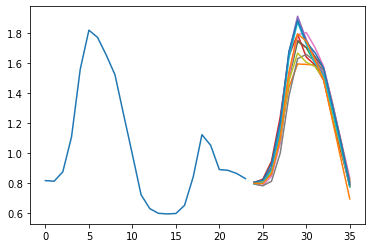

In [126]:
plt.plot(range(24),X_test[0,:,0])
plt.plot(range(24,36), samples_ss_gmmlstm[:10,0,:].T)
plt.plot(range(24,36),Y_test_full[0,:]) #orange
plt.show()